# Basic Network

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../src/")
from collections import OrderedDict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import utils

from keras.models import Sequential
from keras.layers import Activation, Dense, Embedding, Flatten
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Data

In [5]:
data_file = "../data/processed/stacking-data.h5"
df = pd.read_hdf(data_file, "data")

## Model

In [18]:
def get_model(input_length, output_length):
    """
    Return a keras model
    """
    model = Sequential()

    # Embed weeks to a dense space
    model.add(Embedding(54, 10, input_length=input_length))
    model.add(Flatten())
    model.add(Dense(10, W_regularizer=l2(0.08)))
    model.add(Activation("tanh"))
    model.add(Dense(output_length))
                 
    model.compile(loss="mse", optimizer="rmsprop")
    
    return model

get_model(1, 4).summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_16 (Embedding)         (None, 1, 10)         540         embedding_input_16[0][0]         
____________________________________________________________________________________________________
flatten_16 (Flatten)             (None, 10)            0           embedding_16[0][0]               
____________________________________________________________________________________________________
dense_31 (Dense)                 (None, 10)            110         flatten_16[0][0]                 
____________________________________________________________________________________________________
activation_16 (Activation)       (None, 10)            0           dense_31[0][0]                   
___________________________________________________________________________________________

## Training

Creating one model per score (*peak week*, *onset week*, etc.)

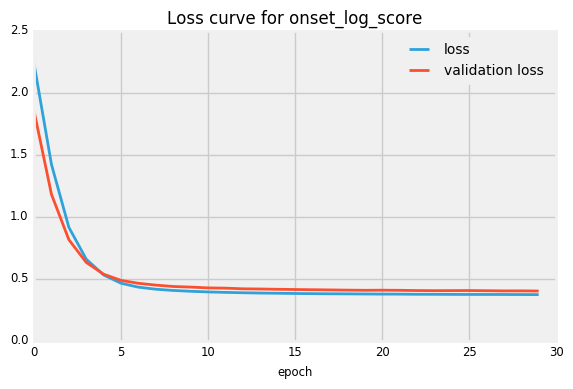

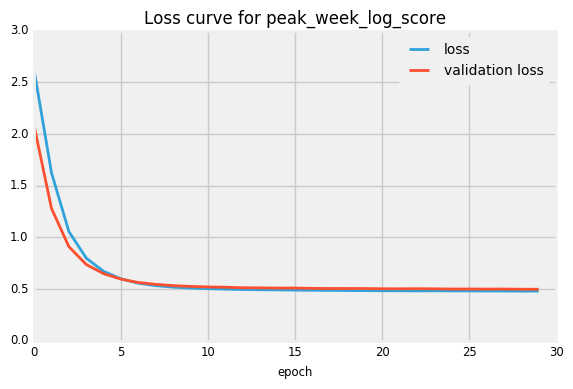

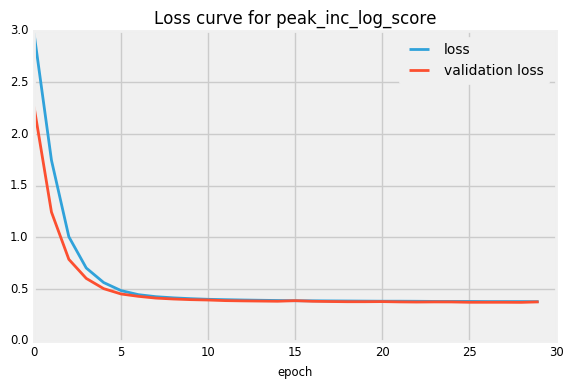

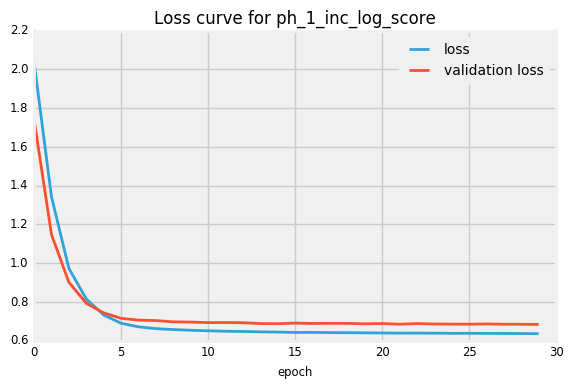

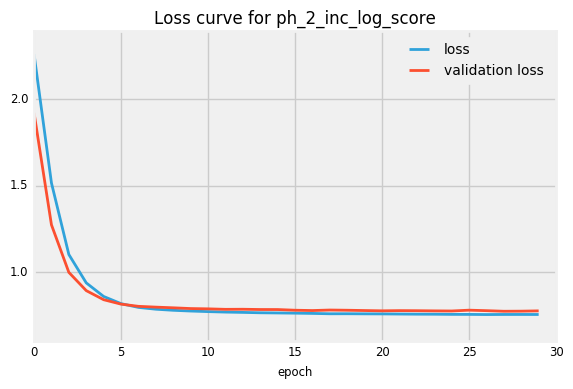

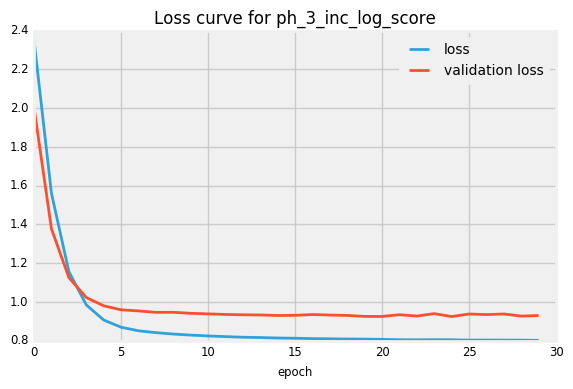

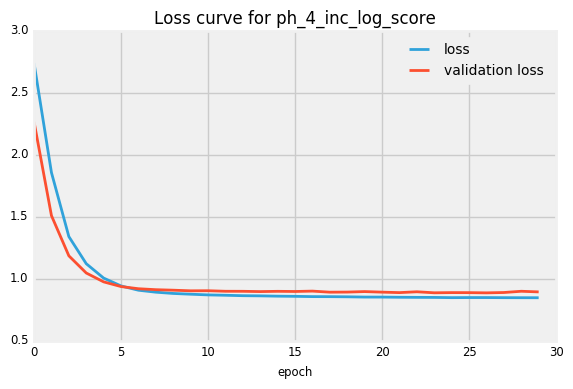

In [19]:
scores = df.columns.levels[0]

models = OrderedDict()

for score in scores:
    X = df[score].index.get_level_values("analysis_time_season_week").values
    y = df[score].as_matrix()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1234)
    
    models[score] = get_model(1, y.shape[1])
    # Using test split for validation as of now
    history = models[score].fit(X_train, y_train, nb_epoch=30, validation_data=(X_test, y_test), verbose=0)
    
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.title("Loss curve for " + score)
    plt.show()

## Score predictions

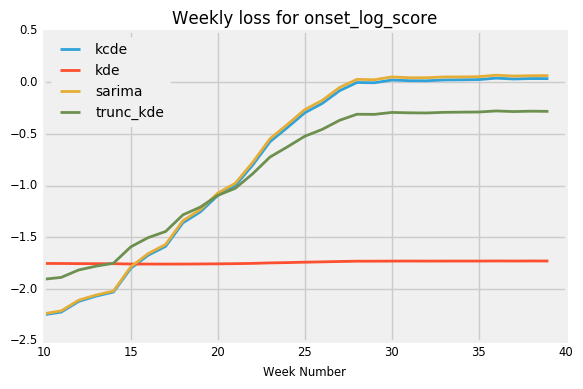

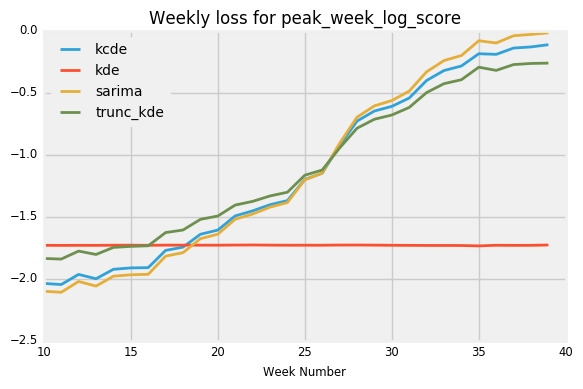

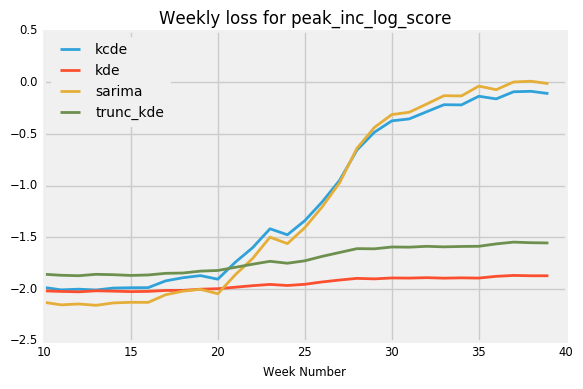

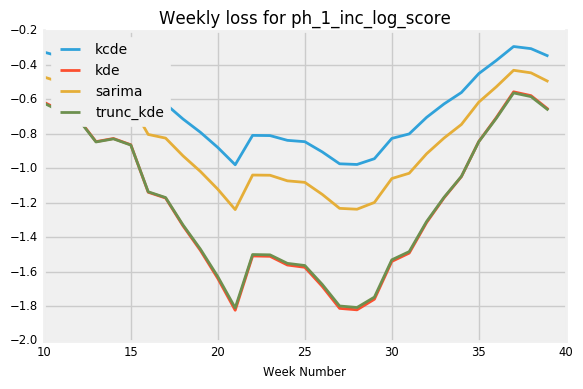

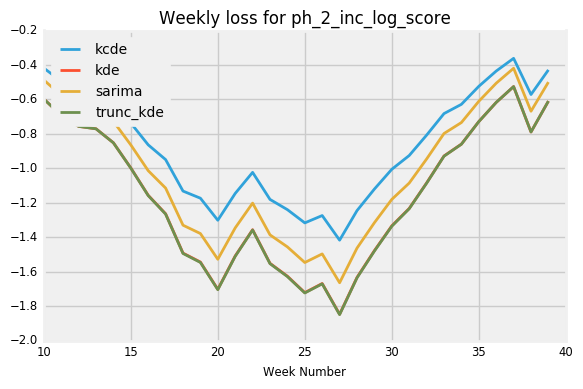

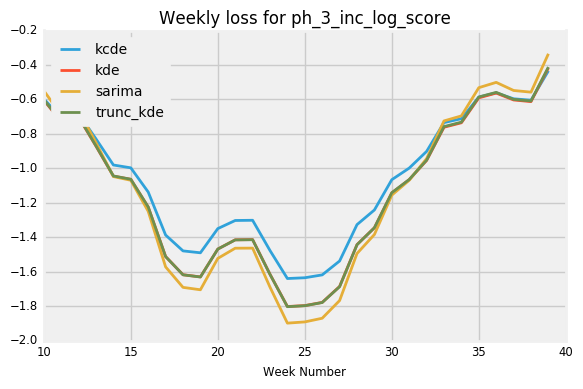

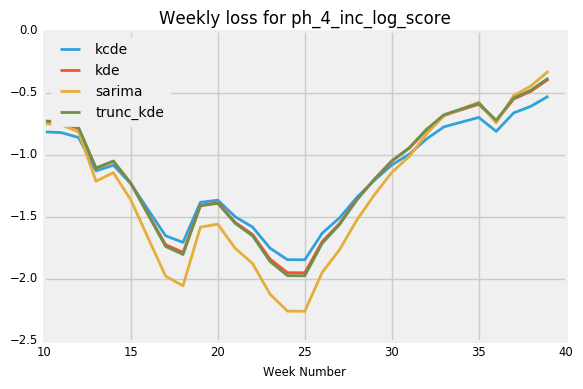

In [20]:
for score, model in models.items():
    weeks = np.arange(10, 40) # Only these weeks are available
    weights = model.predict(weeks)

    for idx, label in enumerate(df["onset_log_score"].columns):
        plt.plot(weeks, weights[:, idx], label=label)
    plt.legend(loc="upper left")
    plt.xlabel("Week Number")
    plt.title("Weekly loss for " + score)
    plt.show()

## Score to weights

Using softmax with variable temperature factor

Increase beta for harder weight preferences

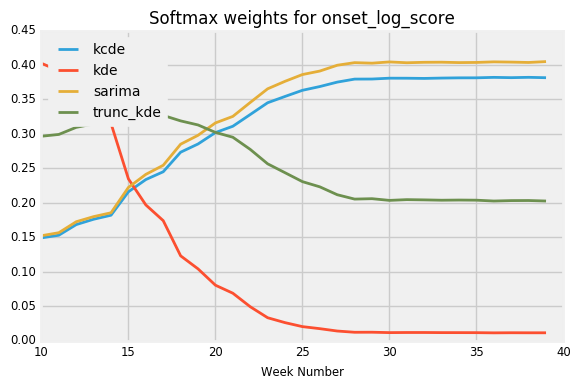

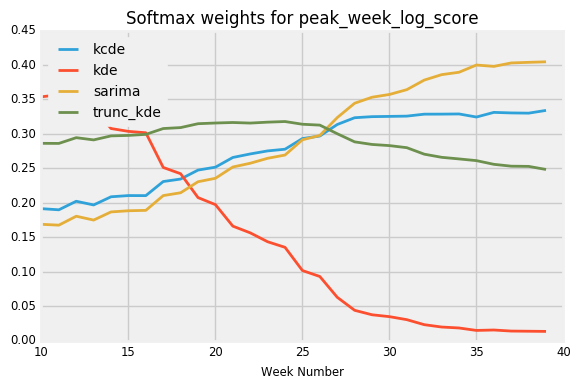

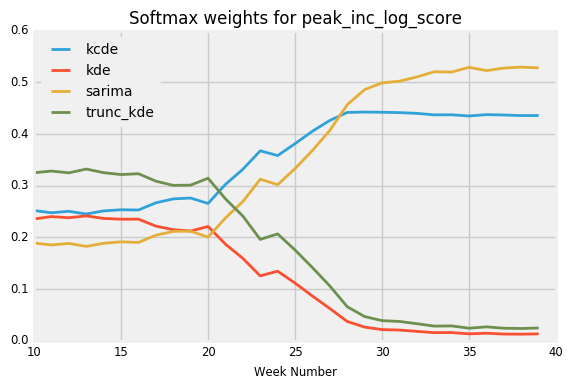

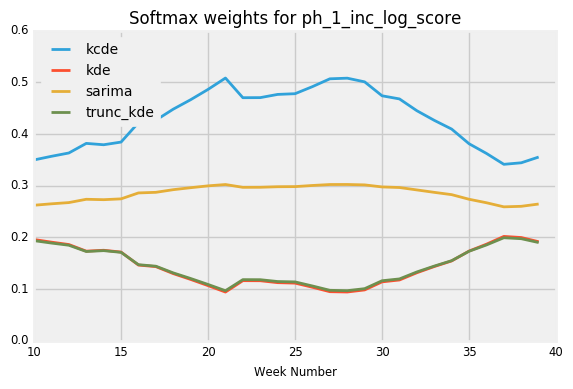

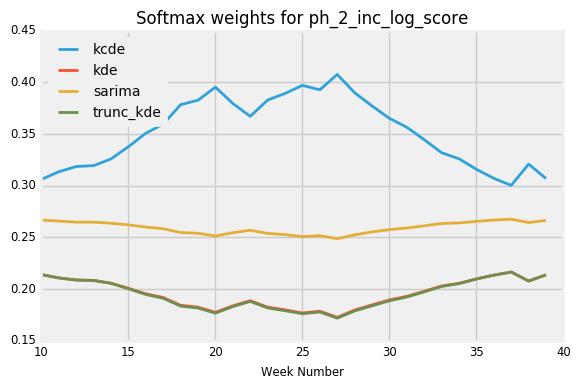

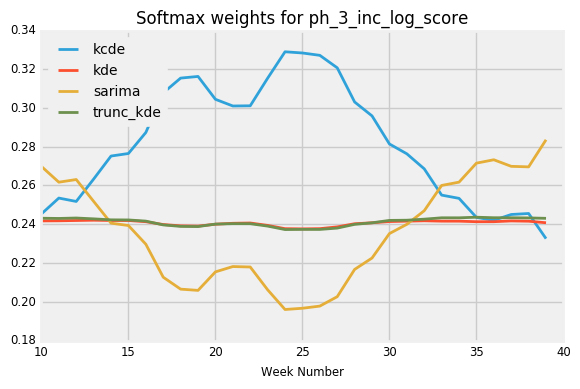

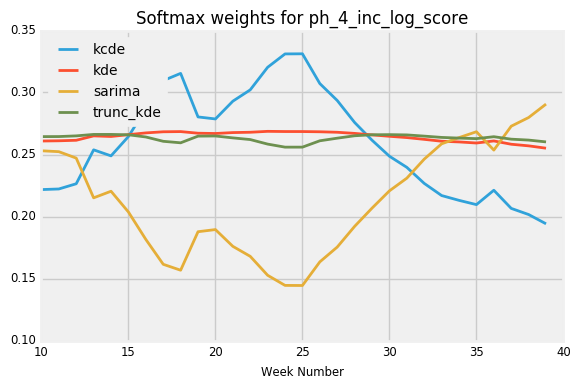

In [21]:
beta = 2

for score, model in models.items():
    weeks = np.arange(10, 40) # Only these weeks are available
    weights = np.exp(beta * model.predict(weeks))
    
    weights = weights / weights.sum(axis=1, keepdims=True)

    for idx, label in enumerate(df["onset_log_score"].columns):
        plt.plot(weeks, weights[:, idx], label=label)
    plt.legend(loc="upper left")
    plt.xlabel("Week Number")
    plt.title("Softmax weights for " + score)
    plt.show()